In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
from einops import rearrange
from PIL import Image
import json
import time
from pathlib import Path
from sklearn import linear_model
import mediapy as media
from tqdm import tqdm

In [4]:
!ls -lt baselines

total 868
drwxrwxrwx 1 chey chey   4096 Oct 18 23:04 session_e503ffa1
-rwxrwxrwx 1 chey chey   2929 Oct 18 23:03 run_pretrained_interactive.py
-rwxrwxrwx 1 chey chey   2932 Oct 18 23:02 run_baseline_parallel.py
drwxrwxrwx 1 chey chey   4096 Oct 18 22:53 session_4d72d8dd
drwxrwxrwx 1 chey chey   4096 Oct 18 21:29 session_12b34429
drwxrwxrwx 1 chey chey   4096 Oct 17 12:19 __pycache__
-rwxrwxrwx 1 chey chey  20155 Oct 17 12:07 red_gym_env.py
-rwxrwxrwx 1 chey chey     17 Oct 16 21:00 agent_enabled.txt
-rwxrwxrwx 1 chey chey   3123 Oct 16 21:00 render_all_needed_grids.py
-rwxrwxrwx 1 chey chey   3167 Oct 15 21:48 tile_vids_to_grid.py
-rwxrwxrwx 1 chey chey   1420 Oct 15 21:48 run_recorded_actions.py
-rwxrwxrwx 1 chey chey   2643 Oct 15 21:48 saves_to_record.txt
-rwxrwxrwx 1 chey chey    218 Oct 15 21:48 requirements-unfrozen.txt
-rwxrwxrwx 1 chey chey   1806 Oct 15 21:48 requirements.txt
-rwxrwxrwx 1 chey chey   1725 Oct 15 21:48 run_baseline.py
-rwxrwxrwx 1 chey chey     84 Oct 15 21:48 

In [5]:
def load_run_data(run_path):
    run_lists = []
    for p in Path(run_path).glob('all_runs_*.json'):
        with open(p, 'r') as f:
            run_lists.append(json.load(f))
    all_runs = [val for tup in zip(*run_lists) for val in tup]
    print(f'runs loaded: {len(all_runs)}')
    return all_runs

In [40]:
def plot_runs(
    all_runs, use_keys=None, 
    plot_fit=False, plot_line=False, 
    start=0, group_runs=1,
    agg_func=np.mean):
    
    all_runs = all_runs[start:]
    x = np.arange(len(all_runs)//group_runs)
    
    def add_plot(y, name, alpha, size, plot_line, plot_fit):
        plt.scatter(x, y, alpha=alpha, s=size, label=name)
        if plot_line:
            plt.plot(x, y, alpha=alpha, label=name)
        if plot_fit:
            regr = linear_model.LinearRegression()
            # Optimize linear model
            regr.fit(x.reshape(-1, 1), y.reshape(-1, 1))

            # Make predictions using the testing set
            lin_y = regr.predict(x.reshape(-1, 1))
            plt.plot(x, lin_y, linewidth=3)
    
    # convert list of dictionaries to dictionary of lists
    metrics = {m: [run[m] for run in all_runs] for m in all_runs[0].keys()}
    metrics['total'] = [sum([v for _,v in run.items()]) for run in all_runs]
    if group_runs:
        for m, dat in metrics.items():
            metrics[m] = agg_func(np.array(dat).reshape(-1, group_runs), 1)
    available_keys = metrics.keys()
    print(f'available metrics: {list(available_keys)}')
    if use_keys is None:
        use_keys = available_keys
    
    ## TODO subplot for each metric ## 
    NUM_COLORS = len(use_keys)
    cm = plt.get_cmap('Dark2')
    cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
    scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
    fig = plt.figure(figsize = (12, 8))

    ax = fig.add_subplot(111)
    ax.set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS)])

    for i, m in enumerate(use_keys):
        add_plot(
            np.array(metrics[m]), m, 1.0, 3.0, plot_line, plot_fit
        )

    plt.title('Reward over runs PPO')
    plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
    plt.show()

In [44]:
def get_latest_grid(pth):
    imgs = np.array([np.array(Image.open(p)) for p in Path(pth).glob('curframe*.jpeg')])
    grid = rearrange(imgs, '(h2 w2) h w c -> (h2 h) (w2 w) c', w2=5)
    return grid

In [45]:
'''
get_im_func = lambda: get_latest_grid('baselines/session_d34118d3')

with media.VideoWriter('test_grid.mp4', get_im_func().shape[:2]) as wr:
    for i in range(500):
        #wr.add_image(get_im_func())
        #time.sleep(1)
'''        

"\nget_im_func = lambda: get_latest_grid('baselines/session_d34118d3')\n\nwith media.VideoWriter('test_grid.mp4', get_im_func().shape[:2]) as wr:\n    for i in range(500):\n        #wr.add_image(get_im_func())\n        #time.sleep(1)\n"

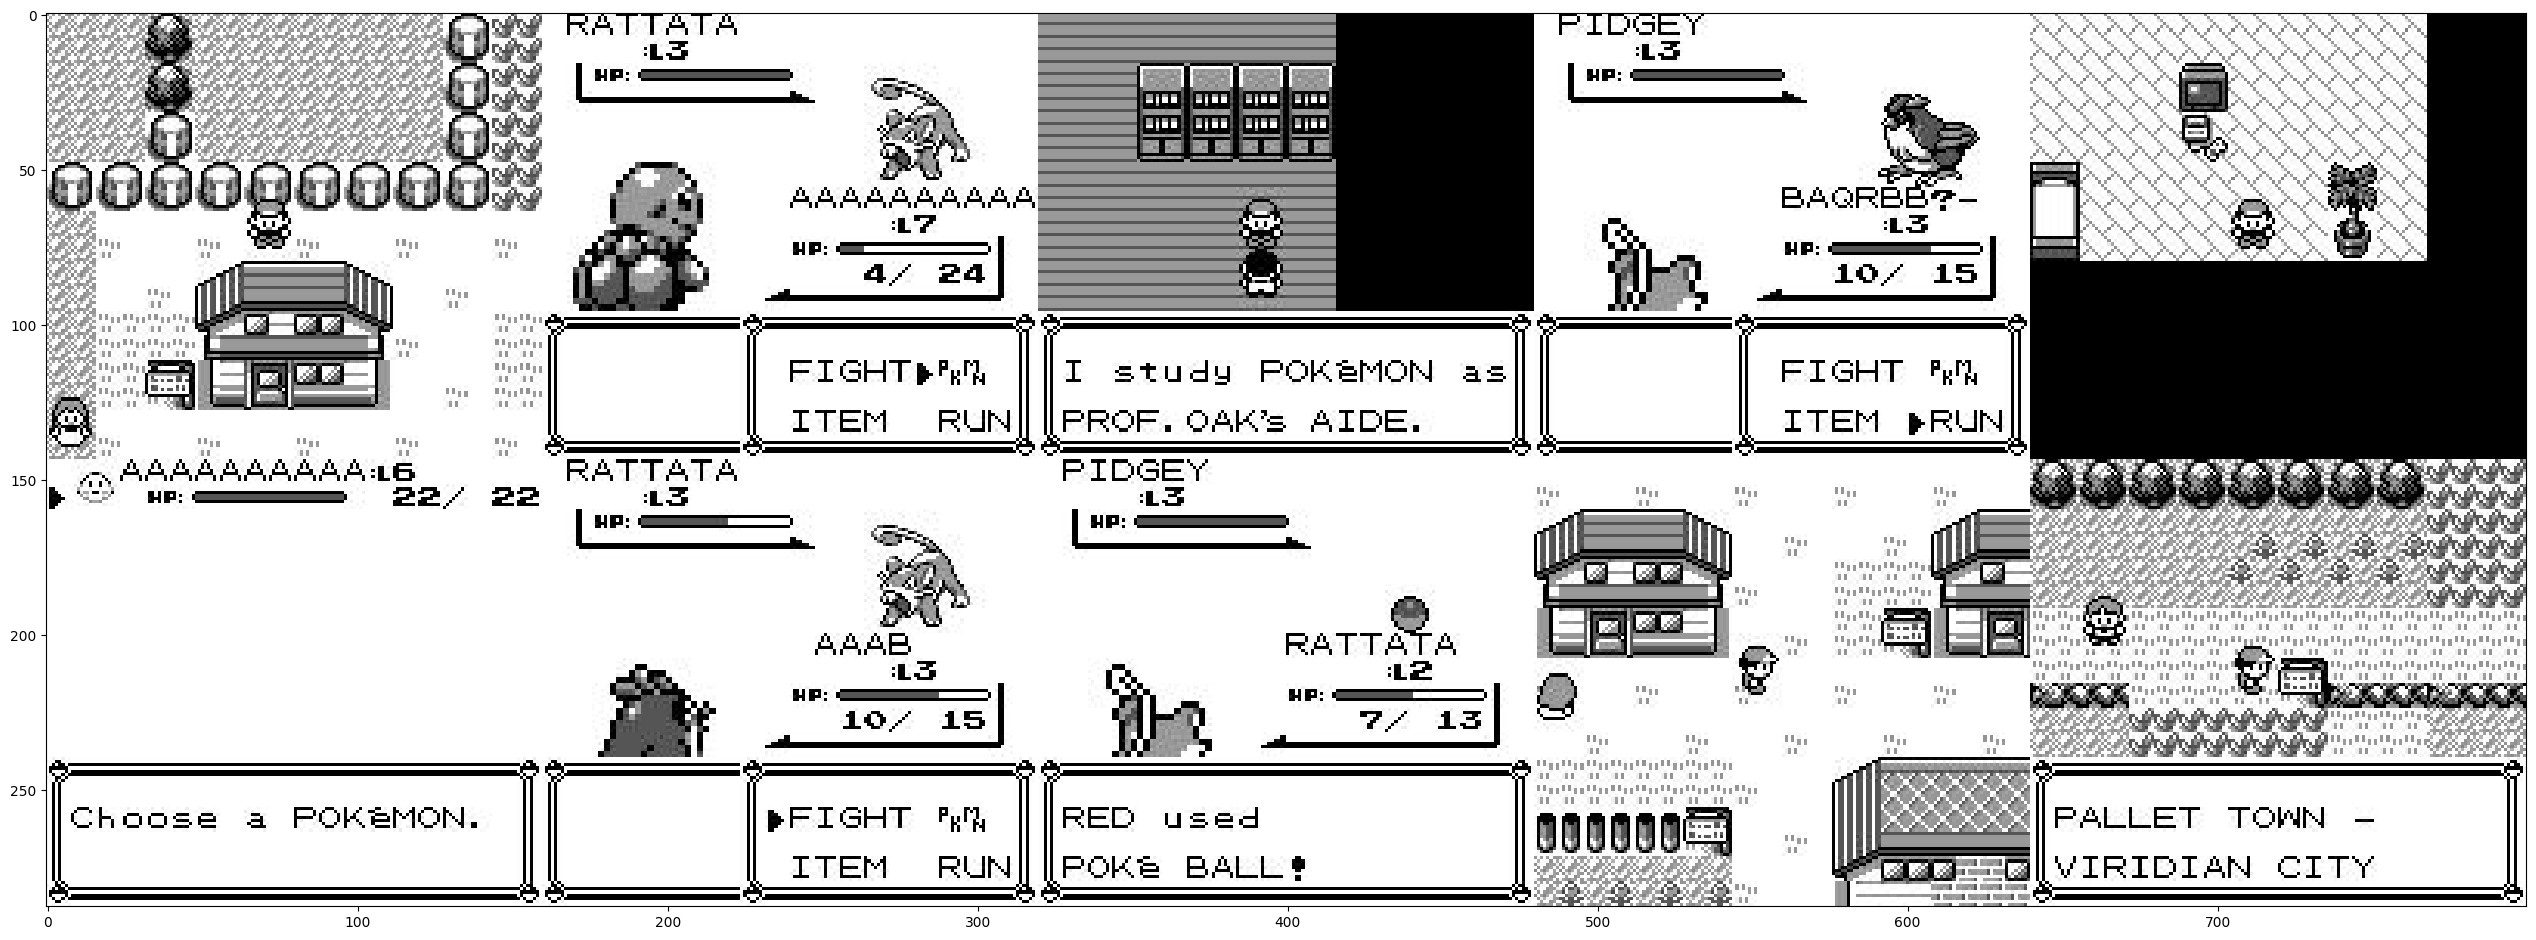

In [46]:
plt.figure(figsize = (32, 32))
plt.imshow(get_latest_grid('baselines/session_12b34429'))

In [11]:
(29556736 - 25952256) / (1024*16*44)

5.0

runs loaded: 2370
available metrics: ['event', 'level', 'heal', 'op_lvl', 'dead', 'badge', 'explore', 'total']


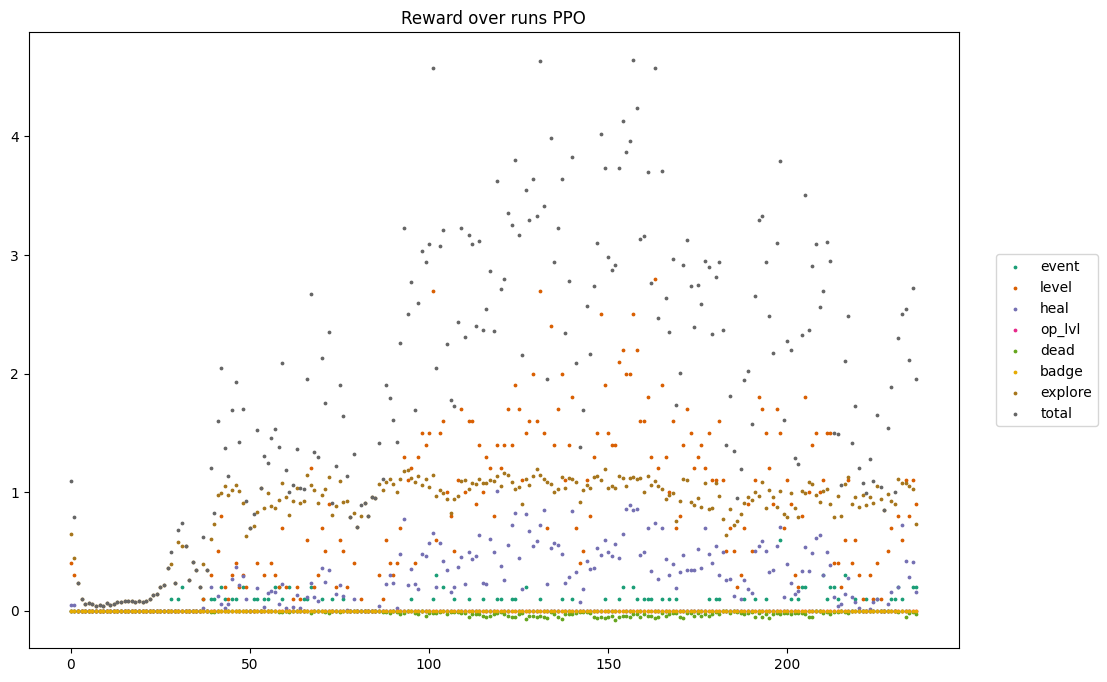

In [43]:
plot_runs(
    load_run_data('baselines/session_12b34429'),
    use_keys=None,
    plot_line=False,
    plot_fit=False,
    start=10*0,
    group_runs=10,
    agg_func=np.mean
)

runs loaded: 2370
available metrics: ['event', 'level', 'heal', 'op_lvl', 'dead', 'badge', 'explore', 'total']


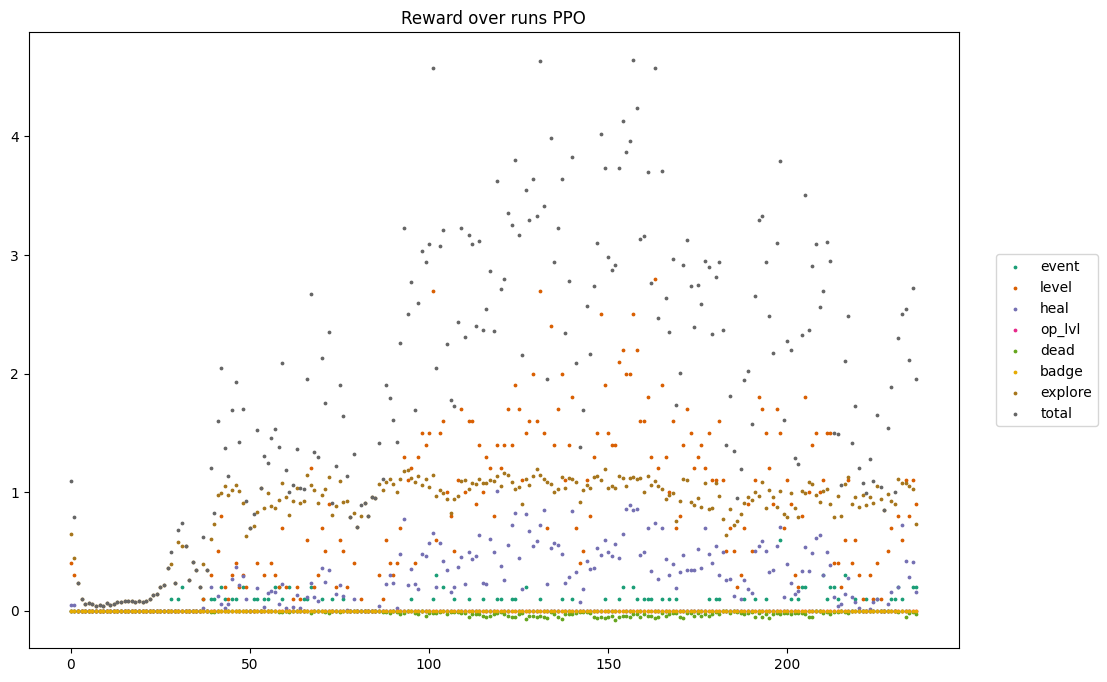

In [44]:
plot_runs(
    load_run_data('baselines/session_12b34429'),
    use_keys=None,
    plot_line=False,
    plot_fit=False,
    start=0,
    group_runs=10,
    agg_func=np.mean
)

runs loaded: 2370
available metrics: ['event', 'level', 'heal', 'op_lvl', 'dead', 'badge', 'explore', 'total']


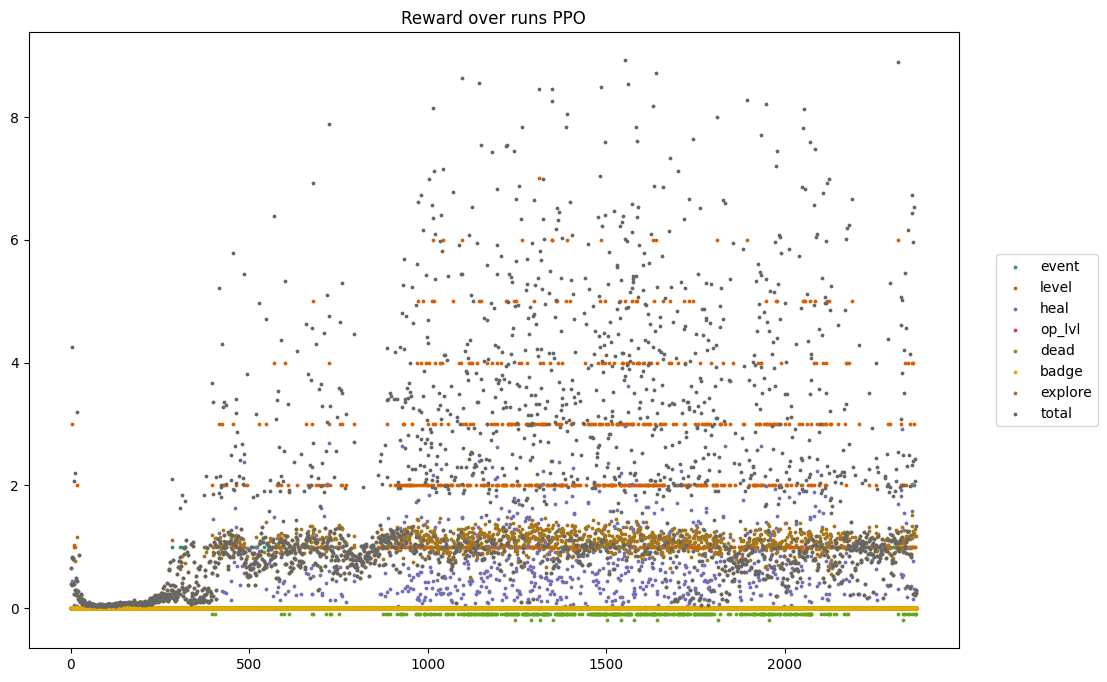

In [46]:
plot_runs(
    load_run_data('baselines/session_12b34429'),
    use_keys=None,
    plot_line=False,
    plot_fit=False,
    start=0,
    group_runs=1,
    agg_func=np.mean
)

runs loaded: 2370
available metrics: ['event', 'level', 'heal', 'op_lvl', 'dead', 'badge', 'explore', 'total']


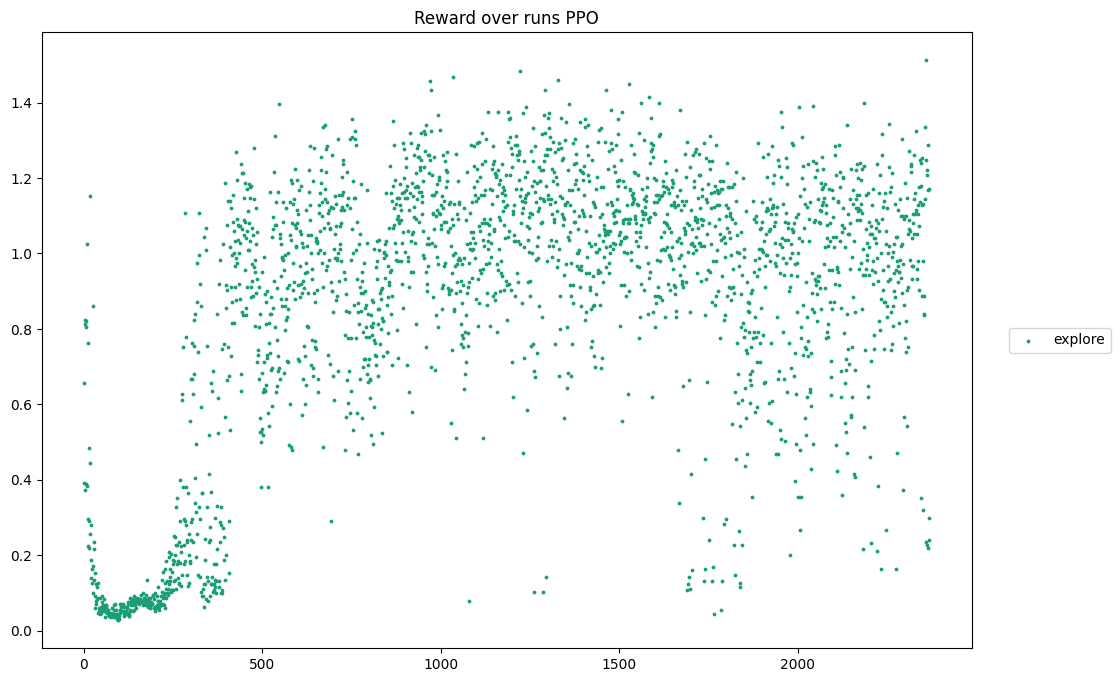

In [48]:

plot_runs(
    load_run_data('baselines/session_12b34429'),
    use_keys=['explore'],
    plot_line=False,
    plot_fit=False,
    start=0,
    group_runs=1,
    agg_func=np.mean
)


runs loaded: 2370
available metrics: ['event', 'level', 'heal', 'op_lvl', 'dead', 'badge', 'explore', 'total']


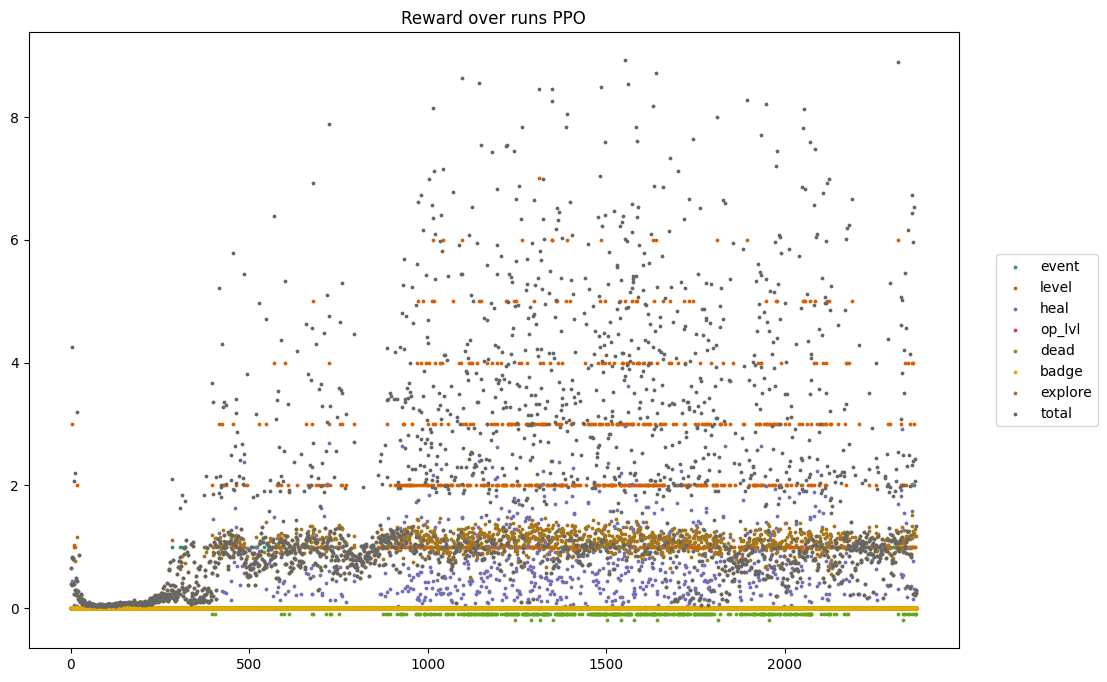

In [49]:

plot_runs(
    load_run_data('baselines/session_12b34429'),
    use_keys=None,
    plot_line=False,
    plot_fit=False,
    start=0,
    group_runs=1,
    agg_func=np.mean
)


## generate moving histograms!

In [50]:
len(load_run_data('baselines/session_12b34429'))

runs loaded: 2370


2370

In [51]:
def chunks(data, n):
    n = max(1, n)
    return [data[i:i+n] for i in range(0, len(data), n)]

In [56]:
full_dat = load_run_data('baselines/session_12b34429')
for run in full_dat:
    run["total"] = sum(value for value in run.values())
full_dat_chunks = chunks(full_dat, 10)

runs loaded: 2370


In [57]:
full_dat[0]

{'event': 0,
 'level': 0,
 'heal': 0,
 'op_lvl': 0.0,
 'dead': -0.0,
 'badge': 0,
 'explore': 0.392,
 'total': 0.392}

In [60]:
def histo_plot(axis, stat, dat_chunks, version, compare_count):
    
    test_dat = np.array([run[stat] for run in dat_chunks[version]])
    # the histogram of the data
    n, bins, patches = axis.hist(test_dat, 10, density=False, facecolor="orange", alpha=0.95)
    
    for i in range(compare_count):
        comp_version = max(version - 1 - i, 0)
        compare_dat = np.array([run[stat] for run in dat_chunks[comp_version]])
        n, bins, patches = axis.hist(compare_dat, 10, density=False, facecolor="grey", alpha=0.2*0.25**i)

    axis.set(xlabel=f"{stat}")
    #axis.ylabel()
    # only use this title over all plots
    #axis.title()
    #plt.xlim(40, 160)
    #plt.ylim(0, 0.03)
    #axis.grid(True)
    #plt.show()

In [61]:
def plot_all(dat_chunks, version, compare_count):
    fig, axs = plt.subplots(2, 4, figsize=(16, 9), dpi=120)
    #plt.subplots_adjust(bottom=0.0, right=0.8, top=0.9)
    fig.suptitle(f"Version {version} Rewards")
    for stat, ax in zip(dat_chunks[0][0].keys(), axs.flatten()):
        histo_plot(ax, stat, dat_chunks, version, compare_count)
    return fig


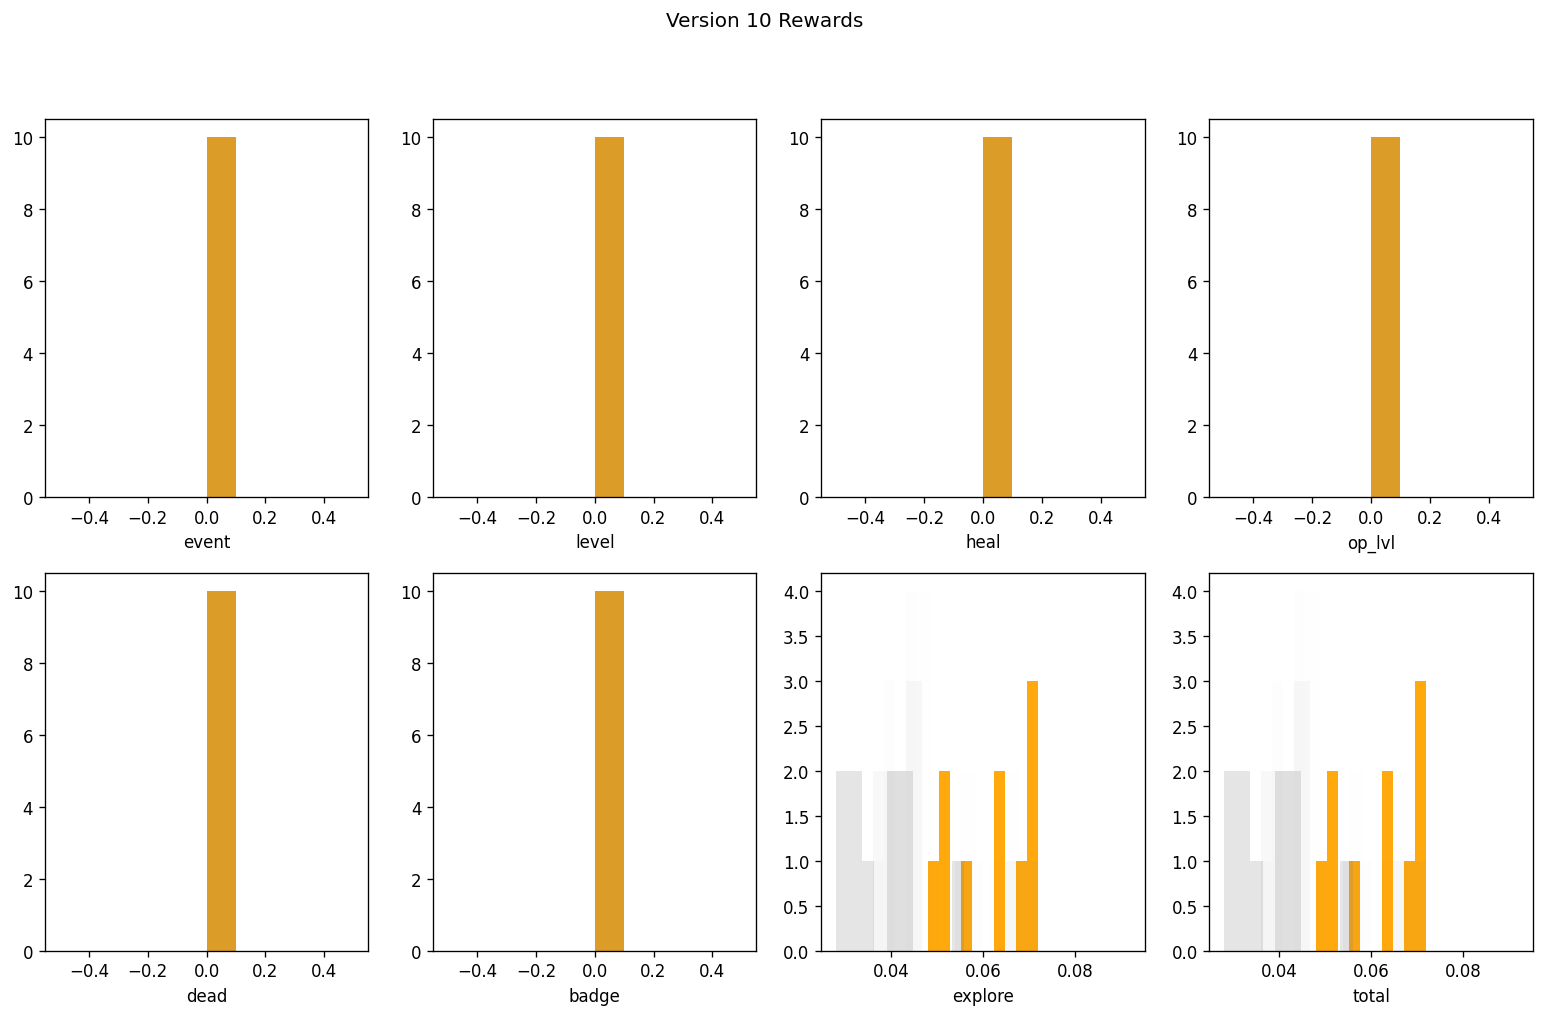

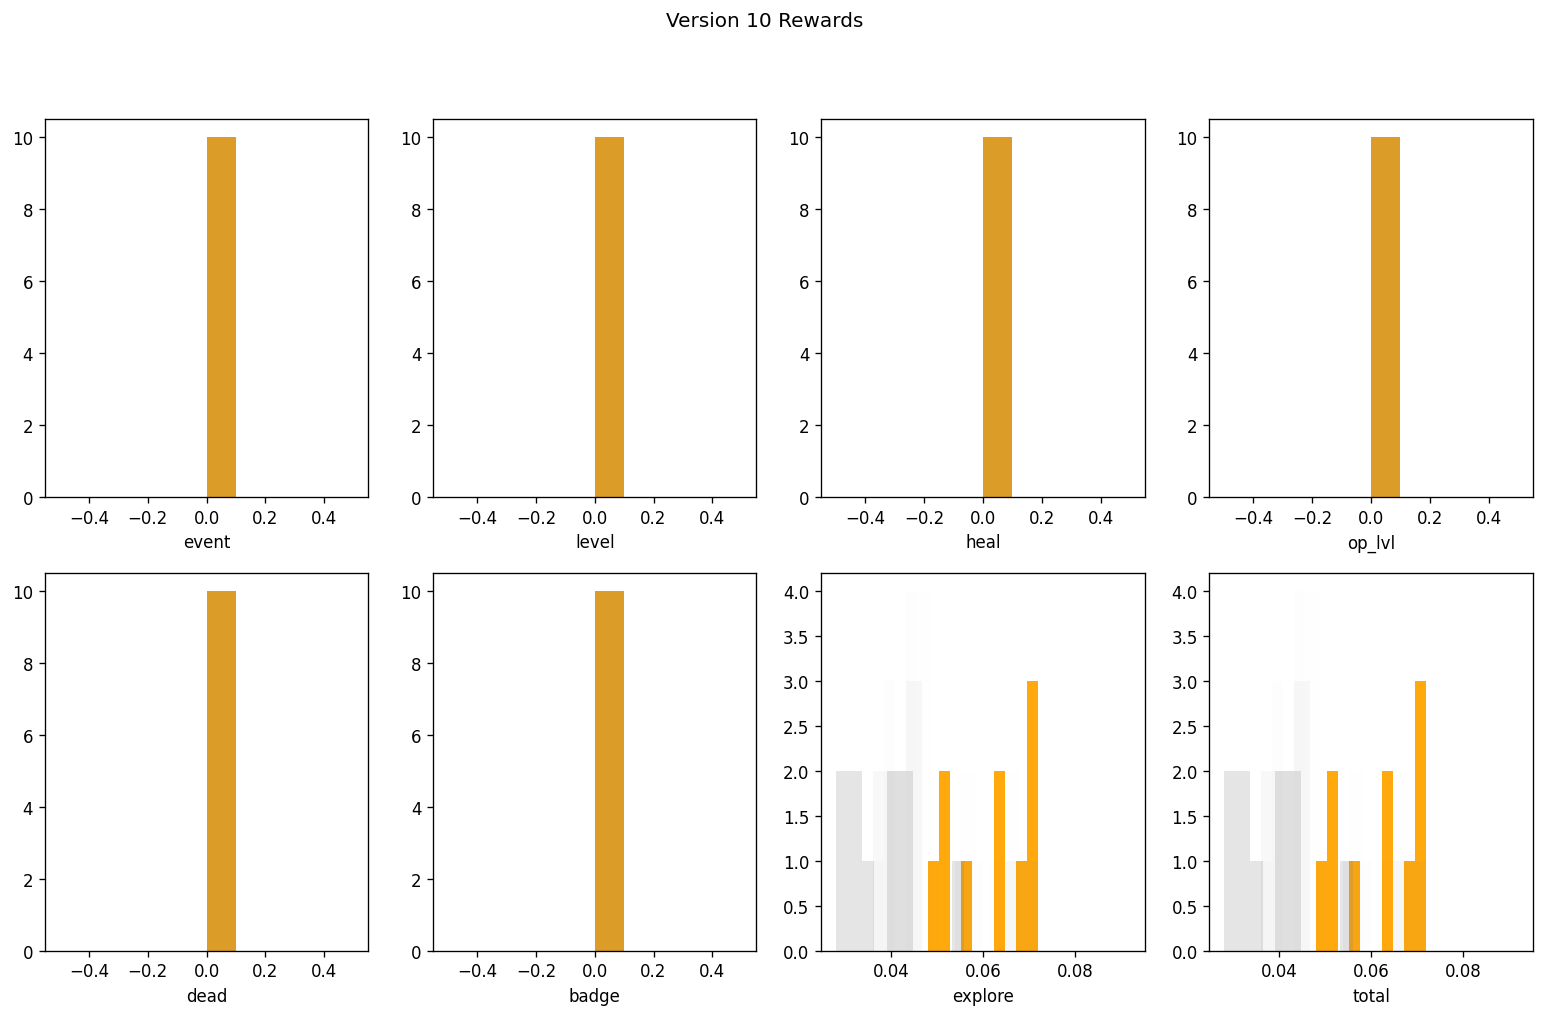

In [63]:
plot_all(chunks(full_dat, 10), 10, 5)

In [67]:
#histo_plot("level", )

 39%|████████████████████████████████████████████████████████████████████▊                                                                                                            | 237/610 [02:16<03:35,  1.73it/s]


IndexError: list index out of range

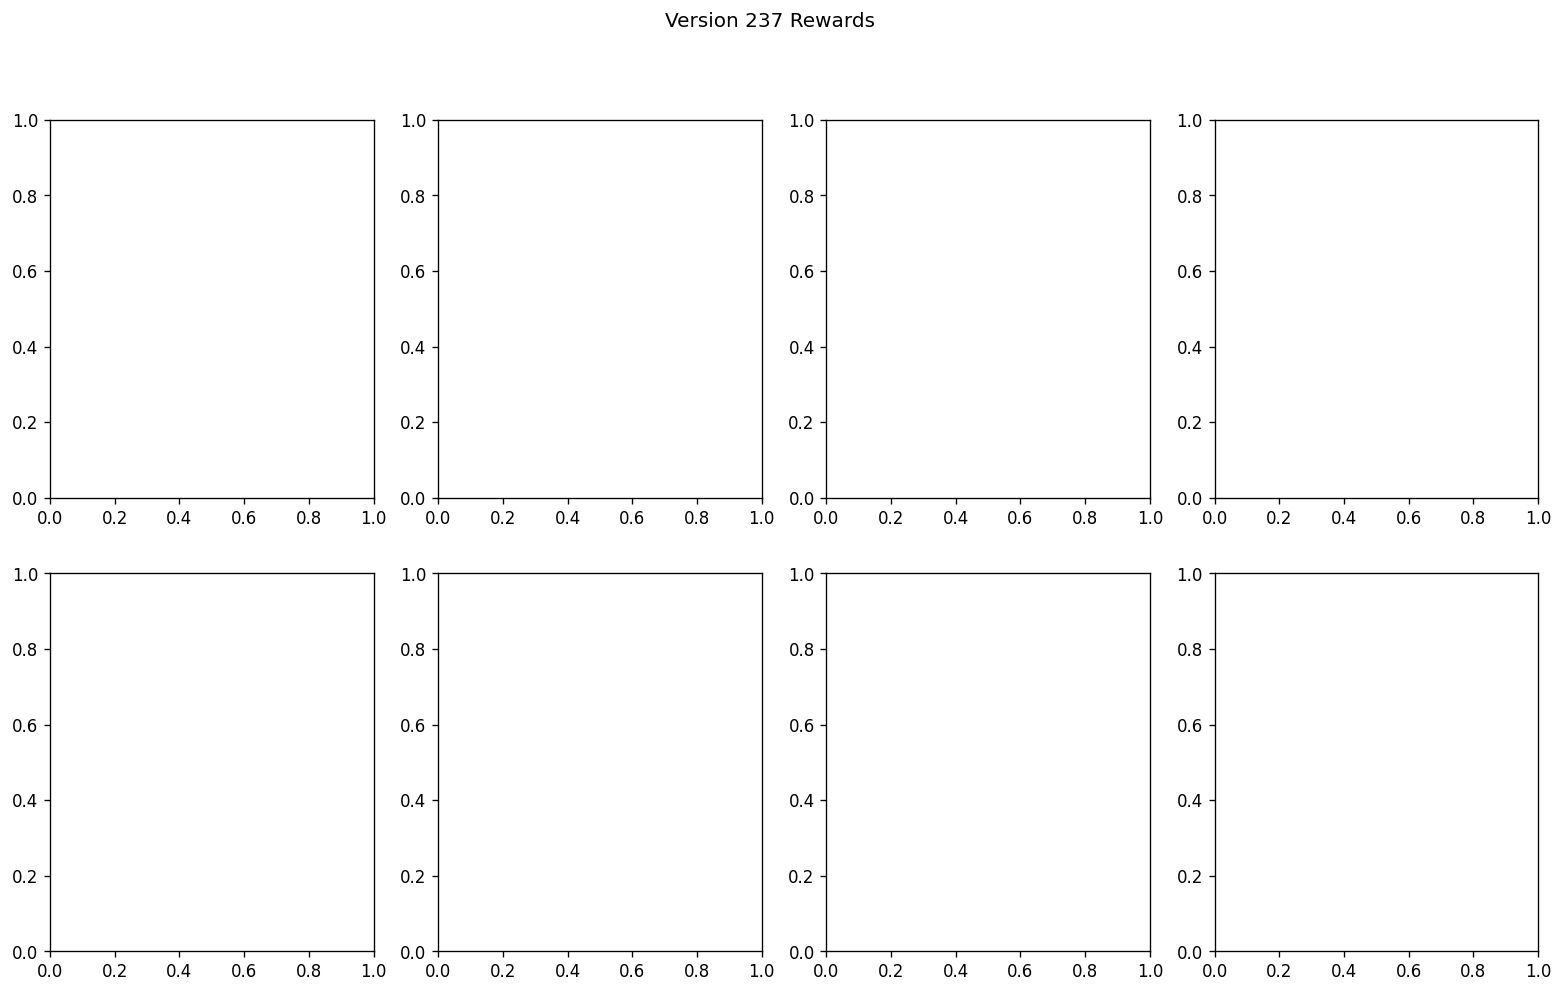

In [69]:
with media.VideoWriter('histograms_over_time.mp4', (1080, 1920)) as wr:
    for i in tqdm(range(610)):
        #with plt.style.context('Solarize_Light2'):
        fig = plot_all(full_dat_chunks, i, 5)

        fig.canvas.draw()
        #plt.show()
        data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        wr.add_image(data)
        plt.close()